In [1]:
import matplotlib as mpl
from Datasets import * 

import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
from LiteModels import DeepLite
from Datasets import *

from MMD.mmd import MMD_3_Sample_Test
import h5py as h5
from tqdm import trange
from scipy.misc import imresize
import seaborn as sns
import pandas as pd

%matplotlib inline

In [2]:
m1 = -1
m2 = 1
s1 = 0.2
s2 = 1.0

N = 10000
alpha = 0.5
D = 1
d1 = np.random.randn(int(N*alpha), D)*s1 + m1
d2 = np.random.randn(int(N*(1-alpha)), D)*s2 + m2
true_density = lambda x: alpha * norm.pdf(x,loc=m1, scale=s1) + (1-alpha)*norm.pdf(x, loc=m2, scale=s2)

p = ArrayDataset(np.concatenate([d1,d2],0), "MOG", ntest=100, whiten=False, itanh=False)

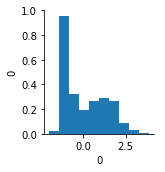

In [3]:
# visualise data
df = pd.DataFrame(p.sample(1000))
sns.pairplot(df,plot_kws=dict(s=4, alpha=1.0, linewidth=0))

manually change LiteNet to set lambdas

In [4]:
dl_model = DeepLite(p, npoint=100, nlayer=0, nneuron=20, init_log_lam=-3, points_std=0.0, keep_prob=1.0, init_weight_std=1.0, noise_std=0.0,
                    points_type="fixed", log_lam_weights=-6, step_size=1e-2, mixture_kernel=False, init_log_sigma=np.linspace(0,1,1), base=True,
                    niter=1000, ntrain=100, nvalid=100, patience=30,gpu_count=1)
res = dl_model.fit(niter=1000, ntrain=100, nvalid=100,ntest=500, nbatch=1, patience=-1)
#dl_model.load()

trainining kernel: 100%|██| 1001/1001 [00:37<00:00, 26.70it/s[{'test': '-6.228', 'loss': '-4.501'}]]

best score: -6.22762


/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/matplotlib/ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


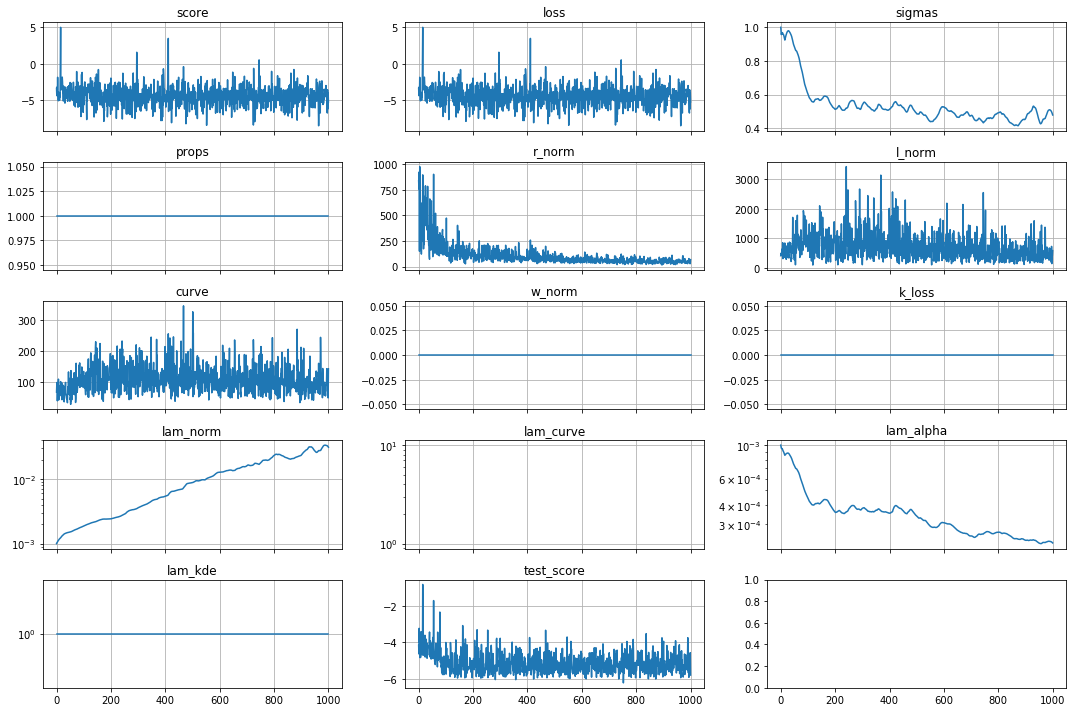

In [5]:
fig, axes = plt.subplots(5,3,figsize=(15,10), sharex=True)

axes = axes.flatten()
res = dl_model.state_hist

for ki, k in  enumerate(res):
    ax = axes[ki]
    ax.plot(res[k])
    ax.set_title(k)
    if "lam" in k: 
        ax.set_yscale("log")
    ax.grid("on")
        
        
fig.tight_layout()

In [6]:
# final fit of alphas. Better do it on cpu so have to redefine the model (set True) and tell it gpu_count = 0
dl_model.set_test(True, 0) 
dl_model.fit_alpha(5000)

INFO:tensorflow:Restoring parameters from ckpts/tmp.ckpt


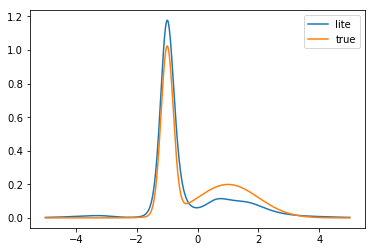

In [7]:
ngrid = 1000
eval_grid = np.linspace(-5,5,ngrid)
fv = dl_model.fun_multiple(eval_grid[:,None])
#fv = fv2 + fv1

density = np.exp(fv)
density /= np.sum(density) * (eval_grid[1]-eval_grid[0])
plt.plot(eval_grid, density, label="lite")

density = true_density(eval_grid)
density /= sum(density) * (eval_grid[1]-eval_grid[0])
plt.plot(eval_grid, density, label="true")
plt.legend()